In [78]:
import torch
import matplotlib.pyplot as plt
import numpy as np

In [99]:
N = 500

def real_model(x):
    y = (torch.randn(1, N) + 2) * x + 3 + torch.randn(1, N)
    return y

x = torch.linspace(-3, 4, N).view(-1, 1)
y = real_model(x.squeeze()).view(-1, 1)

In [100]:
class NormalModel(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.mean = None
        self.std = None

        k = 6

        self.hidden_layers = torch.nn.Sequential(
            torch.nn.Linear(1, k),
            torch.nn.ReLU(),
            torch.nn.Linear(k, k)
        )
        self.mean_layer = torch.nn.Linear(k, 1)
        self.std_layer = torch.nn.Sequential(
            torch.nn.Sigmoid(),
            torch.nn.Linear(k, 1),
            torch.nn.ELU()
        )

    def forward(self, x):
        h = self.hidden_layers(x)
        self.mean = self.mean_layer(h)
        self.std = self.std_layer(h) + 1

        return self.mean, self.std
    
    def __repr__(self):
        return f'Mean: {self.mean.item():.5f} and Std: {self.std.item():.5f}'


In [101]:
def k(mean, std, x):
    return 1 / np.sqrt(2 * np.pi) * torch.exp(-((x - mean)/std) ** 2 / 2) / std

def log_k(mean, std, y):
    return -torch.log(std) - (y - mean)**2 / (2 * std**2)

In [102]:
model = NormalModel()
opt = torch.optim.Adam(model.parameters(), lr=0.01)

In [103]:
max_epoch = 5000
for epoch in range(max_epoch):
    opt.zero_grad()

    if epoch % 10 == 0 and max_epoch - epoch > 100:
        sample = torch.randint(N, (1, 100)).squeeze()
    elif max_epoch - epoch == 100:
        sample = torch.arange(0, N)

    mean, std = model(x[sample])
    log_likelyhood = log_k(mean, std, y[sample]).sum()
    loss = -log_likelyhood
    loss.backward()
    opt.step()

    if epoch % 100 == 0:
        print(f'{epoch}:: Loss = {loss.item()}')
    


0:: Loss = 1615.121826171875
100:: Loss = 130.50718688964844
200:: Loss = 132.57762145996094
300:: Loss = 139.4243927001953
400:: Loss = 123.59944152832031
500:: Loss = 124.69525909423828
600:: Loss = 124.09761047363281
700:: Loss = 124.97296142578125
800:: Loss = 129.9976806640625
900:: Loss = 129.65997314453125
1000:: Loss = 123.5133056640625
1100:: Loss = 130.44558715820312
1200:: Loss = 117.39363098144531
1300:: Loss = 105.99380493164062
1400:: Loss = 119.48007202148438
1500:: Loss = 120.55233764648438
1600:: Loss = 117.53919982910156
1700:: Loss = 119.57777404785156
1800:: Loss = 119.47505187988281
1900:: Loss = 113.19422149658203
2000:: Loss = 106.14028930664062
2100:: Loss = 123.91181945800781
2200:: Loss = 127.44807434082031
2300:: Loss = 130.17982482910156
2400:: Loss = 112.29146575927734
2500:: Loss = 117.65620422363281
2600:: Loss = 112.88270568847656
2700:: Loss = 129.88449096679688
2800:: Loss = 133.1850128173828
2900:: Loss = 130.44200134277344
3000:: Loss = 121.768714904

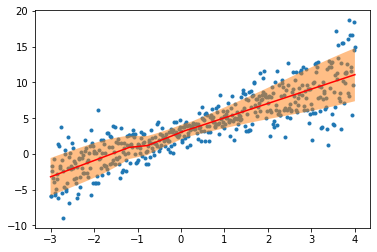

In [104]:
m, s = model(x)

plt.scatter(x, y, marker='.')
plt.plot(x, m.detach(), 'r')
plt.fill_between(x.squeeze(), (m.detach()-s.detach()).squeeze(), (m.detach()+s.detach()).squeeze(), alpha=0.5)

In [105]:
x.size(), y.size()

(torch.Size([500, 1]), torch.Size([500, 1]))

In [106]:
def check_within_two_stddeviations(x, y):
    y_pred, y_std = model(x)
    # want 95.4% inside 
    a = (y - y_pred).abs() / y_std
    hits = (a <= 2).sum()
    return hits / len(x)

In [107]:
check_within_two_stddeviations(x, y) - 0.954

tensor(0.0040)

In [108]:
np.sqrt(0.96 * 0.04 / N)

0.008763560920082658